In [1]:
import os

import matplotlib.pyplot as plt
import numpy as np
from scipy import optimize
import xarray as xr

In [2]:
ds = xr.open_dataset(os.path.join(os.getenv("HOME"), "test_run_phosphorus_wdir", "iterate_02.nc"))
ds

<xarray.Dataset>
Dimensions:       (depth: 30, depth_edges: 31, nbnds: 2)
Coordinates:
  * depth         (depth) float64 5.0 15.01 25.07 35.32 ... 775.1 825.0 875.0
  * depth_edges   (depth_edges) float64 0.0 10.0 20.02 ... 800.0 850.0 900.0
Dimensions without coordinates: nbnds
Data variables:
    depth_bounds  (depth, nbnds) float64 ...
    depth_delta   (depth) float64 ...
    po4           (depth) float64 ...
    dop           (depth) float64 ...
    pop           (depth) float64 ...
    po4_s         (depth) float64 ...
    dop_s         (depth) float64 ...
    pop_s         (depth) float64 ...
Attributes:
    history:  2021-03-31 12:28:20: created by nk_ooc.test_problem.model_state...

In [3]:
def fixed_nodes_nnls(nodes):
    """nnls based soln for fixed nodes"""
    # sum(w * v ** 2) = sum((sqrt(w) * v) ** 2)
    weight = ds["depth_delta"].values[:]
    weight *= 1.0 / weight.sum()
    sqrt_weight = np.sqrt(weight)
    A = np.empty((len(weight), len(nodes)))
    v = np.empty(len(nodes))
    for node_ind, _ in enumerate(nodes):
        v[:] = 0.0
        v[node_ind] = 1.0
        A[:, node_ind] = sqrt_weight * np.interp(ds["depth"].values[:], nodes, v)
    return optimize.nnls(A, sqrt_weight * ds[varname].values[:])

def fixed_nodes_nnls_node_vals(nodes):
    return fixed_nodes_nnls(nodes)[0]

def fixed_nodes_nnls_penalty(nodes):
    return fixed_nodes_nnls(nodes)[1]

def fixed_nodes_delta_nnls_penalty(nodes_delta):
    return fixed_nodes_nnls_penalty(nodes_delta.cumsum())

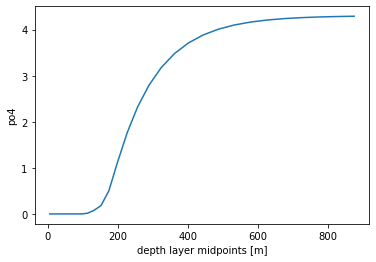

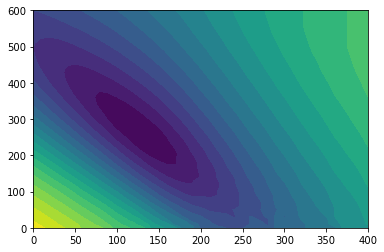

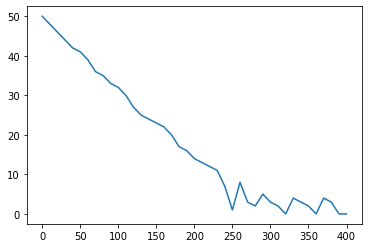

[130. 250.]
(array([0.00842446, 4.13048218]), 0.16965649280127904)
 active_mask: array([0, 0])
        cost: 0.0141220554873426
         fun: array([0.16805984])
        grad: array([-2.13358607e-09, -4.12836616e-08])
         jac: array([[-1.26953949e-08, -2.45648578e-07]])
     message: '`ftol` termination condition is satisfied.'
        nfev: 667
        njev: 492
  optimality: 4.12836616066992e-08
      status: 2
     success: True
           x: array([127.20465689, 258.51980874])
[127.20465689 385.72446564]
(array([0.00524491, 4.14031153]), 0.16805984343288316)
****************************************


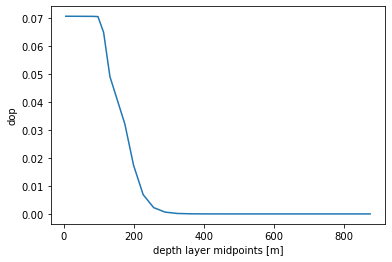

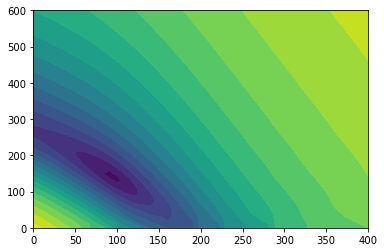

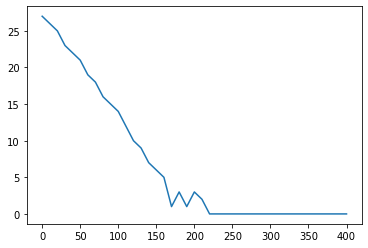

[ 90. 150.]
(array([7.10435010e-02, 9.56577167e-05]), 0.0010316137383573098)
 active_mask: array([0, 0])
        cost: 4.3720256208650006e-07
         fun: array([0.0009351])
        grad: array([-1.17661232e-12,  1.95481891e-14])
         jac: array([[-1.25827928e-09,  2.09050006e-11]])
     message: '`xtol` termination condition is satisfied.'
        nfev: 358
        njev: 260
  optimality: 2.775918221506334e-12
      status: 3
     success: True
           x: array([ 94.63006222, 142.00385573])
[ 94.63006222 236.63391795]
(array([0.07050659, 0.00015106]), 0.0009350963181261062)
****************************************


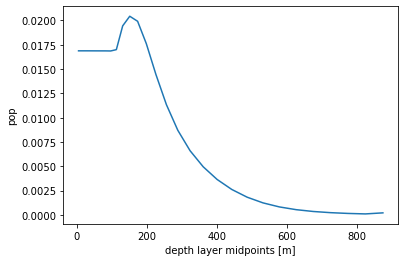

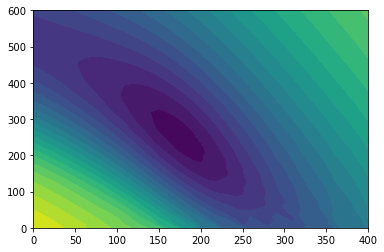

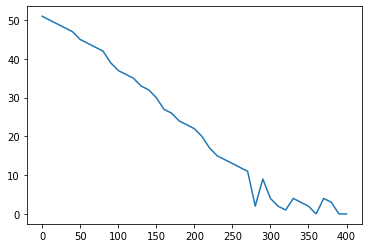

[180. 240.]
(array([0.01778023, 0.00078861]), 0.0010329088419592709)
 active_mask: array([0, 0])
        cost: 5.225627387901971e-07
         fun: array([0.00102231])
        grad: array([ 7.49058544e-12, -8.32052630e-10])
         jac: array([[ 7.32709032e-09, -8.13891626e-07]])
     message: '`xtol` termination condition is satisfied.'
        nfev: 124
        njev: 84
  optimality: 1.3020913581460573e-09
      status: 3
     success: True
           x: array([173.83038586, 247.57130143])
[173.83038586 421.4016873 ]
(array([0.01788667, 0.00079698]), 0.0010223137862615344)
****************************************


In [4]:
for varname in ["po4", "dop", "pop"]:
    ds[varname].plot()
    plt.show()

    h1_vals = np.linspace(0.0, 400.0, 41)
    h2_vals = np.linspace(0.0, 600.0, 61)

    res = np.zeros((len(h2_vals), len(h1_vals)))
    for i1, h1 in enumerate(h1_vals):
        for i2, h2 in enumerate(h2_vals):
            res[i2, i1] = fixed_nodes_delta_nnls_penalty(np.array([h1, h2]))

    plt.contourf(h1_vals, h2_vals, res, 20)
    plt.show()
    
    plt.plot(h1_vals, np.argmin(res, axis=0))
    plt.show()

    ind_min = np.unravel_index(np.argmin(res, axis=None), res.shape)

    nodes_delta_0 = np.array([h1_vals[ind_min[1]], h2_vals[ind_min[0]]])
    print(nodes_delta_0)
    print(fixed_nodes_nnls(nodes_delta_0.cumsum()))

    bounds = ( np.array([0.0, 0.0]), np.array([np.inf, np.inf]) )
    tol = 1.0e-11 * ds[varname].max()
    res = optimize.least_squares(
        fixed_nodes_delta_nnls_penalty, nodes_delta_0, bounds=bounds, max_nfev=10000, ftol=tol, gtol=tol
    )
    print(res)
    print(res.x.cumsum())
    print(fixed_nodes_nnls(res.x.cumsum()))
    print(40 * "*")

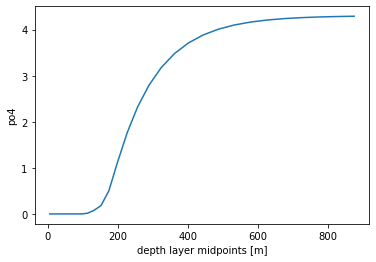

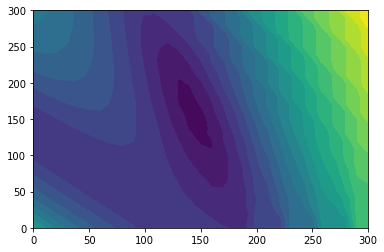

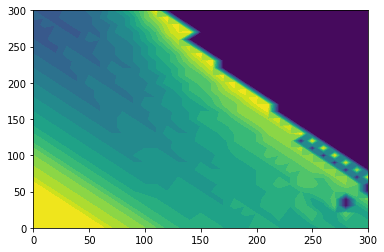

[140. 170. 240.]
(array([0.00520295, 3.26041044, 4.24676943]), 0.06187645964477387)
 active_mask: array([0, 0, 0])
        cost: 0.0018177806381142357
         fun: array([0.06029562])
        grad: array([-1.18711209e-09, -2.96695573e-09, -1.13654799e-08])
         jac: array([[-1.96881992e-08, -4.92068236e-08, -1.88495959e-07]])
     message: '`ftol` termination condition is satisfied.'
        nfev: 461
        njev: 333
  optimality: 1.1365479887641962e-08
      status: 2
     success: True
           x: array([143.14067386, 162.29641565, 241.51910778])
[143.14067386 305.43708951 546.95619729]
(array([0.0153278 , 3.22123353, 4.24608537]), 0.060295615729740015)
****************************************


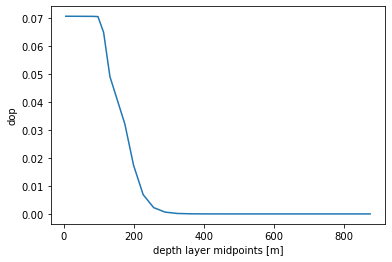

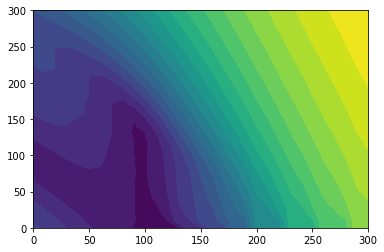

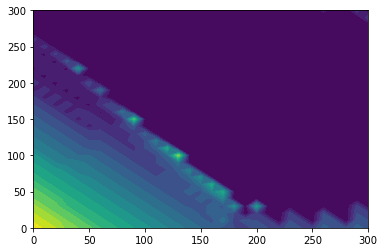

[110.  10. 120.]
(array([0.07039895, 0.05481371, 0.00015561]), 0.0006063637610070631)
 active_mask: array([0, 0, 0])
        cost: 1.7675383093296003e-07
         fun: array([0.00059457])
        grad: array([-4.51254466e-13, -5.15456624e-13, -5.23542961e-13])
         jac: array([[-7.58965610e-10, -8.66947322e-10, -8.80547745e-10]])
     message: '`gtol` termination condition is satisfied.'
        nfev: 193
        njev: 135
  optimality: 5.23542960785484e-13
      status: 1
     success: True
           x: array([109.24017615,  10.35649045, 120.4661383 ])
[109.24017615 119.5966666  240.0628049 ]
(array([0.07049115, 0.05509753, 0.00015106]), 0.000594565103134989)
****************************************


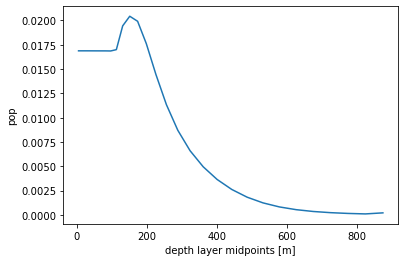

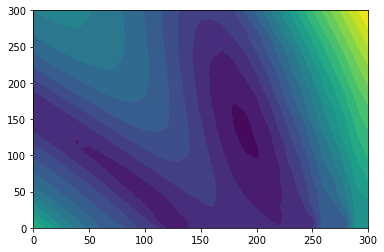

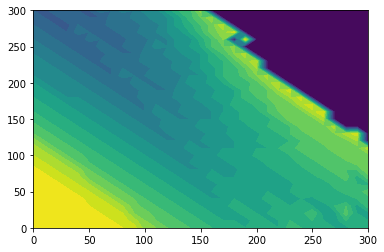

[190. 120. 240.]
(array([0.01799151, 0.0063852 , 0.00034298]), 0.0007219818722840119)
 active_mask: array([0, 0, 0])
        cost: 2.5939327738790813e-07
         fun: array([0.00072027])
        grad: array([-4.35565076e-15, -9.28416487e-15, -1.99873695e-13])
         jac: array([[-6.04726074e-12, -1.28898685e-11, -2.77498912e-10]])
     message: '`gtol` termination condition is satisfied.'
        nfev: 485
        njev: 343
  optimality: 1.9987369474891475e-13
      status: 1
     success: True
           x: array([192.50918139, 117.97444909, 240.09443324])
[192.50918139 310.48363048 550.57806372]
(array([0.01794562, 0.00632239, 0.00034493]), 0.0007202683907931933)
****************************************


In [5]:
for varname in ["po4", "dop", "pop"]:
    ds[varname].plot()
    plt.show()

    h1_vals = np.linspace(0.0, 300.0, 31)
    h2_vals = np.linspace(0.0, 300.0, 31)
    h3_vals = np.linspace(0.0, 400.0, 41)

    res = np.zeros((len(h3_vals), len(h2_vals), len(h1_vals)))
    for i1, h1 in enumerate(h1_vals):
        for i2, h2 in enumerate(h2_vals):
            for i3, h3 in enumerate(h3_vals):
                res[i3, i2, i1] = fixed_nodes_delta_nnls_penalty(np.array([h1, h2, h3]))

    plt.contourf(h1_vals, h2_vals, res.min(axis=0), 20)
    plt.show()

    plt.contourf(h1_vals, h2_vals, np.argmin(res, axis=0), 20)
    plt.show()

    ind_min = np.unravel_index(np.argmin(res, axis=None), res.shape)

    nodes_delta_0 = np.array([h1_vals[ind_min[2]], h2_vals[ind_min[1]], h3_vals[ind_min[0]]])
    print(nodes_delta_0)
    print(fixed_nodes_nnls(nodes_delta_0.cumsum()))

    bounds = ( np.array([0.0, 0.0, 0.0]), np.array([np.inf, np.inf, np.inf]) )
    tol = 1.0e-11 * ds[varname].max()
    res = optimize.least_squares(
        fixed_nodes_delta_nnls_penalty, nodes_delta_0, bounds=bounds, max_nfev=10000, ftol=tol, gtol=tol
    )
    print(res)
    print(res.x.cumsum())
    print(fixed_nodes_nnls(res.x.cumsum()))
    print(40 * "*")